![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: Linear Regression and Optimization

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/iwh-halle/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/iwh-halle/FinancialDataAnalytics/discussions

In this assignment you will work with data that is stored in a file named **02_python_data.csv**, which contains daily stock prices for various companies listed on Deutsche Börse (Xetra). The columns are labeled with Reuters identifier code (RIC). The first RIC '.GDAXI' is the german DAX index, the remaining RICs represent its constituents.

In this exercise we will compare the **DAX index** (.GDAXI) to a portfolio build from the **constituents** (the remaining columns).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import optimize

# Read data from CSV file
prices = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)
returns = prices.pct_change()
returns = returns.iloc[1:,::]

### Task:

Find the vector of weights $\mathbf{w}$ for the [Minimum Variance Portfolio (MVP)](https://en.wikipedia.org/wiki/Modern_portfolio_theory) using only the constituents (not .GDAXI). Print risk ($\sigma$) and return ($\mu$) of both, DAX and MVP. Show in a single graph the cumulative log-returns of both portfolios. Please note that the sum of $\mathbf{w}$ must be $100$%. ALso, you are not allowed to use short positions, i.e. $w \ge 0\ \forall\ w \in \mathbf{w}$.

Hint: The portfolio variance - which we want to minimize - is given by
$$
\sigma^2_\text{Portfolio} = \mathbf{w}^\intercal \mathbf{\Sigma} \mathbf{w},
$$
where $\mathbf{\Sigma}$ is the correlation matrix of the portfolio constituents.

Optimized Weights: [0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103]
DAX Risk (σ): 0.012071011349327105, DAX Return (μ): 0.00047873151098818805
MVP Risk (σ): 0.012842130123511685, MVP Return (μ): 0.0002582539899206422


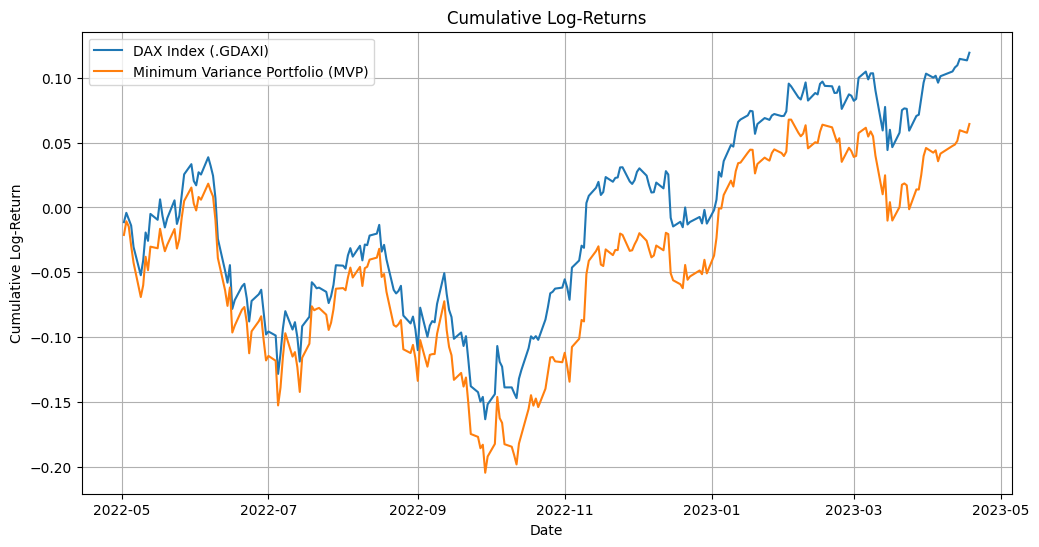

In [1]:
import pandas as pd
import numpy as np

# Load the stock price data
file_path = '02_python_data.csv'
prices = pd.read_csv(file_path, index_col=0, parse_dates=True)

# Calculate daily log-returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Exclude the DAX index
constituents_log_returns = log_returns.drop(columns=['.GDAXI'])

# Calculate the covariance matrix of the log-returns of the constituents
cov_matrix = constituents_log_returns.cov()

from scipy.optimize import minimize

# Number of assets
num_assets = constituents_log_returns.shape[1]

# Initial guess for the weights (equally weighted)
initial_weights = np.ones(num_assets) / num_assets

# Constraints: Weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: Weights between 0 and 1 (no short positions)
bounds = tuple((0, 1) for _ in range(num_assets))

# Define the function to calculate portfolio variance
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Optimize the portfolio weights
optimized_result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimized weights
optimized_weights = optimized_result.x
print(f"Optimized Weights: {optimized_weights}")

# Calculate the optimized portfolio returns
optimized_portfolio_log_returns = constituents_log_returns @ optimized_weights

# Calculate the risk (standard deviation) and return (mean log-return) of the optimized portfolio
mvp_risk = np.std(optimized_portfolio_log_returns)
mvp_return = np.mean(optimized_portfolio_log_returns)

# Calculate the risk (standard deviation) and return (mean log-return) of the DAX index
dax_risk = np.std(log_returns['.GDAXI'])
dax_return = np.mean(log_returns['.GDAXI'])

print(f"DAX Risk (σ): {dax_risk}, DAX Return (μ): {dax_return}")
print(f"MVP Risk (σ): {mvp_risk}, MVP Return (μ): {mvp_return}")

import matplotlib.pyplot as plt

# Plot cumulative log-returns
plt.figure(figsize=(12, 6))
plt.plot(log_returns.index, log_returns['.GDAXI'].cumsum(), label='DAX Index (.GDAXI)')
plt.plot(log_returns.index, optimized_portfolio_log_returns.cumsum(), label='Minimum Variance Portfolio (MVP)')
plt.title('Cumulative Log-Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Return')
plt.legend()
plt.grid(True)
plt.show()


### Task:

Use a linear regression model to find the actual weights of the index constituents that are required to replicate (i.e. explain) the returns of the DAX index. Print risk and return and show in a single graph the cumulative log-returns of both portfolios. Also show the [tracking error](https://en.wikipedia.org/wiki/Tracking_error) as the difference between the index and the replicating portfolio in the same figure.

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the stock price data
file_path = '02_python_data.csv'  # Ensure this is the correct path to your data file
prices = pd.read_csv(file_path, index_col=0, parse_dates=True)

# Calculate daily log-returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Exclude the DAX index
constituents_log_returns = log_returns.drop(columns=['.GDAXI'])

# Prepare the data for regression
X = constituents_log_returns
y = log_returns['.GDAXI']

# Add a constant to the independent variable
X = sm.add_constant(X)

# Perform linear regression
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

# Extract the weights (regression coefficients), excluding the constant term
replicating_weights = model.params[1:]
print(f"Replicating Weights: {replicating_weights}")

# Ensure weights sum to 1 by normalizing
normalized_weights = replicating_weights / replicating_weights.sum()
print(f"Normalized Replicating Weights: {normalized_weights}")

# Calculate the replicating portfolio returns
replicating_portfolio_log_returns = constituents_log_returns @ normalized_weights

# Calculate the risk (standard deviation) and return (mean log-return) of the replicating portfolio
replicating_risk = np.std(replicating_portfolio_log_returns)
replicating_return = np.mean(replicating_portfolio_log_returns)

# Calculate the risk (standard deviation) and return (mean log-return) of the DAX index
dax_risk = np.std(log_returns['.GDAXI'])
dax_return = np.mean(log_returns['.GDAXI'])

print(f"DAX Risk (σ): {dax_risk}, DAX Return (μ): {dax_return}")
print(f"Replicating Portfolio Risk (σ): {replicating_risk}, Replicating Portfolio Return (μ): {replicating_return}")

# Calculate tracking error
tracking_error = log_returns['.GDAXI'] - replicating_portfolio_log_returns
tracking_error_std = np.std(tracking_error)
print(f"Tracking Error (σ): {tracking_error_std}")

# Plot cumulative log-returns
plt.figure(figsize=(12, 6))
plt.plot(log_returns.index, log_returns['.GDAXI'].cumsum(), label='DAX Index (.GDAXI)')
plt.plot(log_returns.index, replicating_portfolio_log_returns.cumsum(), label='Replicating Portfolio')
plt.plot(log_returns.index, tracking_error.cumsum(), label='Tracking Error (Cumulative)')
plt.title('Cumulative Log-Returns and Tracking Error')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Return')
plt.legend()
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'statsmodels'

### Task:

We want to create a ["smart-beta"](https://en.wikipedia.org/wiki/Smart_beta) strategy that replicates the DAX index returns using only a subset of its constituents. This is, maximize the fit of the model using only $3$ constituents. This process is similar to [feature selection](https://en.wikipedia.org/wiki/Feature_selection) in machine learning. Print risk and return and show in a single graph the cumulative log-returns of both portfolios. Also show the [tracking error](https://en.wikipedia.org/wiki/Tracking_error) as the difference between the index and the replicating portfolio in the same figure.

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt

# Load the stock price data
file_path = '02_python_data.csv'  # Ensure this is the correct path to your data file
prices = pd.read_csv(file_path, index_col=0, parse_dates=True)

# Calculate daily log-returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Exclude the DAX index
constituents_log_returns = log_returns.drop(columns=['.GDAXI'])

# Define a function to perform feature selection and return the best 3 constituents
def select_best_constituents(X, y, num_features=3):
    best_score = float('inf')
    best_combination = None
    for combination in itertools.combinations(X.columns, num_features):
        X_subset = X[list(combination)]
        X_subset = sm.add_constant(X_subset)
        model = sm.OLS(y, X_subset).fit()
        score = model.bic  # Using Bayesian Information Criterion (BIC) for model selection
        if score < best_score:
            best_score = score
            best_combination = combination
    return best_combination

# Select the best 3 constituents
selected_constituents = select_best_constituents(constituents_log_returns, log_returns['.GDAXI'])
print(f"Selected Constituents: {selected_constituents}")

# Prepare the data for regression using the selected constituents
X_selected = constituents_log_returns[list(selected_constituents)]
X_selected = sm.add_constant(X_selected)

# Perform linear regression
model = sm.OLS(log_returns['.GDAXI'], X_selected).fit()

# Display the regression results
print(model.summary())

# Extract the weights (regression coefficients), excluding the constant term
replicating_weights = model.params[1:]
print(f"Replicating Weights: {replicating_weights}")

# Ensure weights sum to 1 by normalizing
normalized_weights = replicating_weights / replicating_weights.sum()
print(f"Normalized Replicating Weights: {normalized_weights}")

# Calculate the replicating portfolio returns
replicating_portfolio_log_returns = X_selected.iloc[:, 1:].dot(normalized_weights)

# Calculate the risk (standard deviation) and return (mean log-return) of the replicating portfolio
replicating_risk = np.std(replicating_portfolio_log_returns)
replicating_return = np.mean(replicating_portfolio_log_returns)

# Calculate the risk (standard deviation) and return (mean log-return) of the DAX index
dax_risk = np.std(log_returns['.GDAXI'])
dax_return = np.mean(log_returns['.GDAXI'])

print(f"DAX Risk (σ): {dax_risk}, DAX Return (μ): {dax_return}")
print(f"Replicating Portfolio Risk (σ): {replicating_risk}, Replicating Portfolio Return (μ): {replicating_return}")

# Calculate tracking error
tracking_error = log_returns['.GDAXI'] - replicating_portfolio_log_returns
tracking_error_std = np.std(tracking_error)
print(f"Tracking Error (σ): {tracking_error_std}")

# Plot cumulative log-returns
plt.figure(figsize=(12, 6))
plt.plot(log_returns.index, log_returns['.GDAXI'].cumsum(), label='DAX Index (.GDAXI)')
plt.plot(log_returns.index, replicating_portfolio_log_returns.cumsum(), label='Replicating Portfolio')
plt.plot(log_returns.index, tracking_error.cumsum(), label='Tracking Error (Cumulative)')
plt.title('Cumulative Log-Returns and Tracking Error')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Return')
plt.legend()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'statsmodels'